In [15]:
import numpy as np
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
COLORS = list(colors.CSS4_COLORS.keys())
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import warnings
import scipy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import random
import FloRodMethods as frm

%matplotlib inline

In [16]:
def load_region(file):  
    df = pd.read_csv(file)
    df.index = df['timestamp']
    del df['timestamp']
    return df

In [17]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]
#useful tool for seeing which day of the year marks the beginning of various months
DAYS_SUM = [sum(DAYS[0:k]) for k in range(12)]
DAYS_SUM

[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

In [18]:
df = load_region('county1000.csv')

In [19]:
df

,194565,22533,280581,10250,118794,225290,243737,159770,311322,323609,...,24549,282597,124905,120810,12266,215017,278506,8169,149497,249854
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:15:00,27.90,9.260,4.000,7.610,4.490,20.80,2.271,34.06,4.406,4.520,...,1.214,0.4448,1.1320,12.625,6.137,1.201,24.60,3.834,5.586,2.172
2018-01-01 00:30:00,31.20,9.266,3.973,7.613,4.490,20.81,2.488,32.60,4.402,4.520,...,1.203,0.3374,1.2440,12.550,6.082,1.201,23.97,3.800,5.360,2.172
2018-01-01 00:45:00,27.67,9.280,3.895,7.620,4.490,20.81,2.396,31.64,4.290,4.520,...,1.141,0.3403,0.9910,12.440,6.040,1.201,23.94,3.684,5.273,2.172
2018-01-01 01:00:00,27.66,9.305,3.852,7.630,4.490,20.83,2.162,30.97,4.230,4.520,...,1.606,0.3152,0.9893,12.375,5.543,1.201,23.95,3.710,5.200,2.172
2018-01-01 01:15:00,28.17,28.530,3.871,23.530,4.594,31.47,2.658,26.61,4.020,13.370,...,4.150,2.3520,1.4750,13.400,6.387,5.970,32.56,3.258,5.125,2.428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:00:00,29.17,9.195,4.270,7.550,4.490,21.38,2.164,44.47,4.610,4.523,...,2.035,0.5140,0.7275,16.890,6.240,1.201,24.40,4.070,7.510,2.172
2018-12-31 23:15:00,28.78,9.195,4.130,7.566,4.490,21.27,2.420,41.50,4.492,4.523,...,1.847,0.5273,0.9795,13.090,6.230,1.201,24.00,3.992,6.926,2.172
2018-12-31 23:30:00,28.58,9.220,4.086,7.580,4.490,21.20,2.484,39.70,4.450,4.523,...,1.624,0.5454,0.9480,13.016,6.227,1.201,24.05,3.941,6.598,2.172


In [20]:
clusters = np.load('kmeans112.npy')

In [21]:
data = np.asarray(df[DAYS_SUM[5]*24*4:DAYS_SUM[8]*24*4]).astype('float16').T
#only rows corresponding to june through august, and transposing it in the form of an array

In [22]:
blds, t_len = data.shape

In [23]:
num_days = t_len//(24*4)
num_days

92

In [24]:
data_days = data.reshape(blds,num_days,24*4)
#tensor of blds, by days, by daily measurements

In [25]:
two_days = np.zeros((blds,num_days-1,24*4*2))
for i in range(num_days-1):
    two_days[:,i,:] = np.concatenate([data_days[:,i,:],data_days[:,i+1,:]],axis=1)
#similar as above but now it's two day blocks, s.t. we have day 0 through 1, 1 through 2, etc.

## Choosing a cluster

In [26]:
c = 71

In [27]:
blds_in_c = np.squeeze(np.argwhere((clusters==71).astype(int)))
print('cluster: ',c,' \nhas buildings: ',blds_in_c)
blds_tst =  blds_in_c[[1,4,8]]
print('we choose: ',blds_tst)


cluster:  71  
has buildings:  [ 128  148  282  362  699  801  834 1001 1064]
we choose:  [ 148  699 1064]


Building  128  in cluster  71


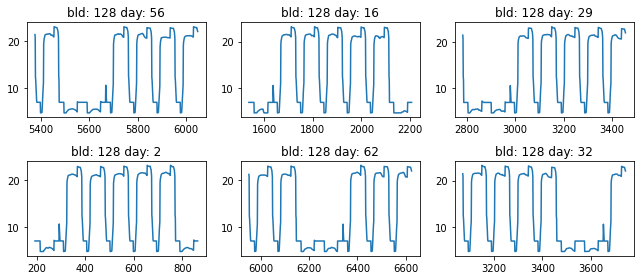



Building  148  in cluster  71


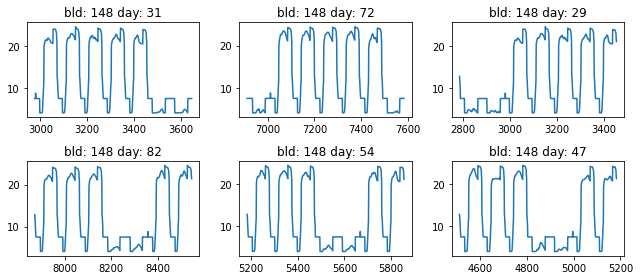



Building  282  in cluster  71


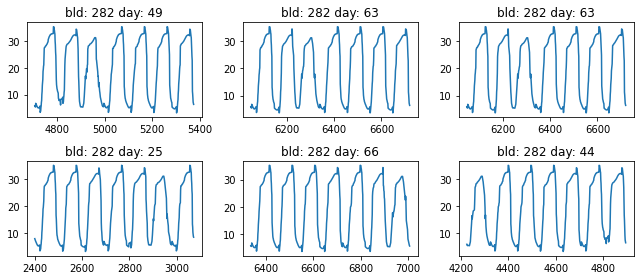



Building  362  in cluster  71


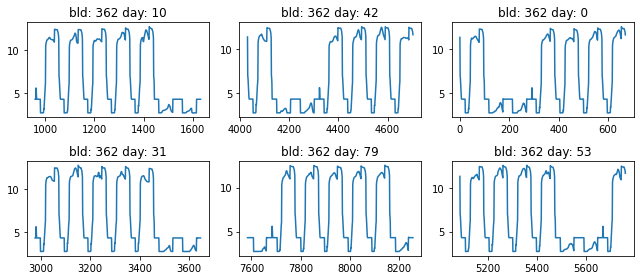



Building  699  in cluster  71


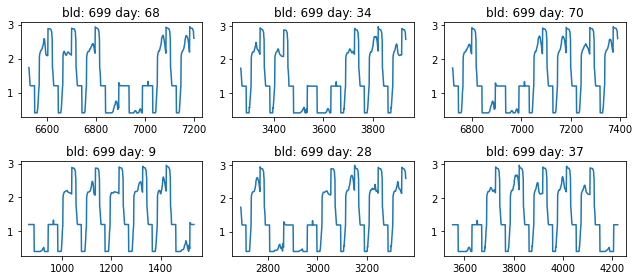



Building  801  in cluster  71


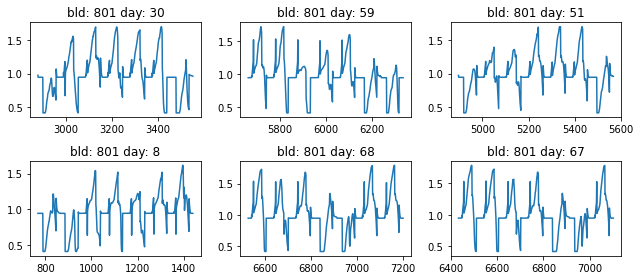



Building  834  in cluster  71


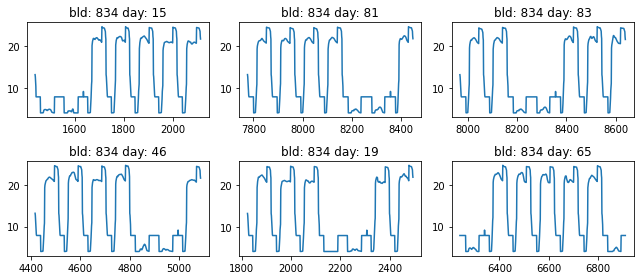



Building  1001  in cluster  71


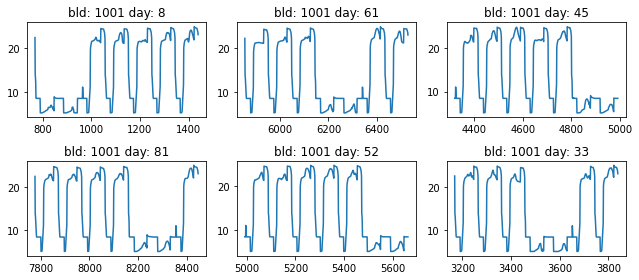



Building  1064  in cluster  71


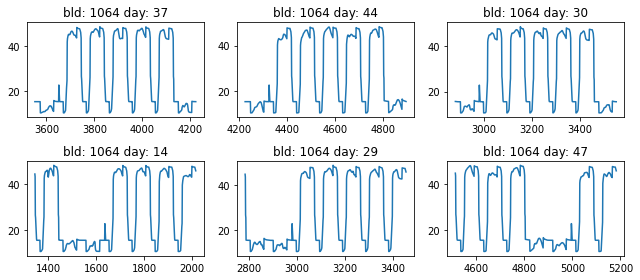

In [28]:
#data analysis
for j in blds_in_c:
    print('Building ',j,' in cluster ',c)
    plt.subplots(2,3, figsize = (9,4))
    bld = j
    for i in range(6):
        plt.subplot(2,3,i+1)
        day = np.random.randint(0,num_days-8)
        plt.plot(np.arange(day*24*4,(day+7)*24*4),data[bld,day*24*4:(day+7)*24*4])
        plt.title('bld: '+str(bld)+ ' day: '+str(day))
    plt.tight_layout()
    plt.show()
    print('\n')

In [29]:
xs = {}
for bld in blds_in_c:
    x,y = frm.splitSeqs(data[bld],14*24*4,24*4)
    xs['x'+str(bld)] = x
    xs['y'+str(bld)] = y

In [30]:
for k in xs:
    print(k,xs[k].shape)

x128 (7393, 1344)
y128 (7393, 96)
x148 (7393, 1344)
y148 (7393, 96)
x282 (7393, 1344)
y282 (7393, 96)
x362 (7393, 1344)
y362 (7393, 96)
x699 (7393, 1344)
y699 (7393, 96)
x801 (7393, 1344)
y801 (7393, 96)
x834 (7393, 1344)
y834 (7393, 96)
x1001 (7393, 1344)
y1001 (7393, 96)
x1064 (7393, 1344)
y1064 (7393, 96)


In [31]:
x,y = xs['x128'],xs['y128']

In [18]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

def generate_real_samples(x,n):
    # generate inputs in [-0.5, 0.5]
    np.random.shuffle(x)
    X = x[:n,:]
    # generate class labels
    y = ones((n, 1))
    return X, y
 

In [19]:
x = (x-np.mean(x,1,keepdims=True))/np.std(x,1,keepdims=True)

C:\Users\DJFRO\Miniconda3\envs\navidi\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


### The GAN works in general

999 0.8799999952316284 0.03999999910593033


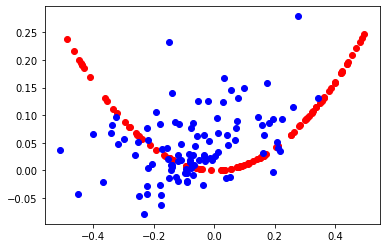

191.37876439094543
1999 0.3700000047683716 0.9300000071525574


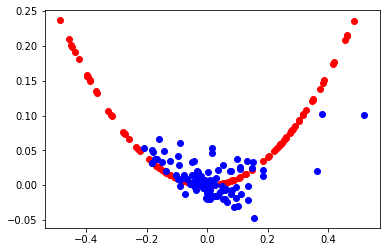

367.07209491729736
2999 0.47999998927116394 0.6600000262260437


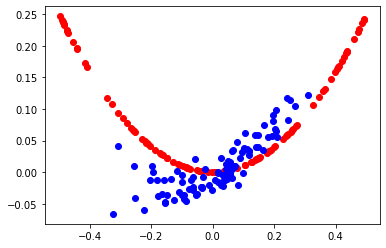

517.7240836620331
3999 0.6899999976158142 0.28999999165534973


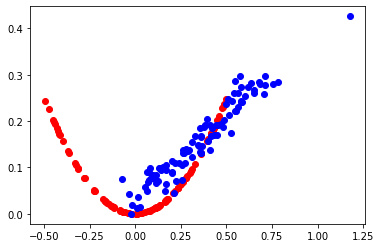

2002.9169914722443
4999 0.3199999928474426 0.6399999856948853


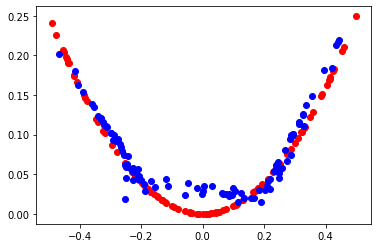

2161.929981470108
5999 0.5699999928474426 0.5699999928474426


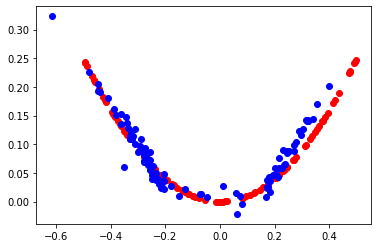

2332.7472400665283


In [13]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import time
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=32, n_eval=500):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	t1 = time.time()
    
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)
			print(time.time()-t1)

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, n_epochs =6000, n_eval = 1000)

400
7010
841
4402
1172
5352
6197
154
5717
1647
2366
5099
5675
1925
6524
3140
27
2639
646
3304


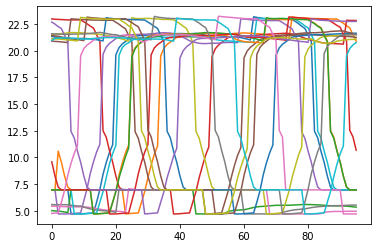

In [34]:
for i in np.random.randint(0,y.shape[0],20):
    plt.plot(y[i])
    print(i)
    #ensuring we have reasonable days

2076
6760
5073
4982
6309
5182
5946
6659
3949
7045
2970
4668
4402
164
1715
3766
2074
6796
6915
2373


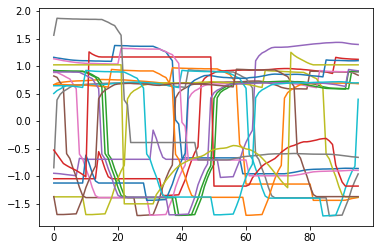

In [35]:
normy = (y - np.mean(y,axis=1,keepdims=True))/np.std(y, axis=1,keepdims=True)
for i in np.random.randint(0,y.shape[0],20):
    plt.plot(normy[i])
    print(i)
    #normalizing the data

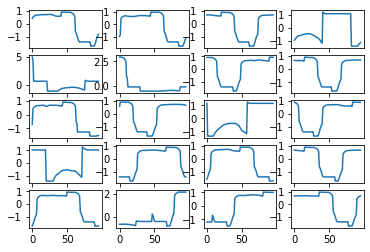

In [38]:
sampleRows =normy[np.random.choice(normy.shape[0], 20, replace=False), :]
## code for choosing random rows of matrix normy without replacement
## here, we choose 20 rows
plt.subplots(5,4)
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(sampleRows[i])

## OH, we should CENTER the days we are trying to build, otherwise the model won't see the day night pattern

In [42]:
dataclust = data[128].reshape(-1,96)
dataclust.shape

(92, 96)

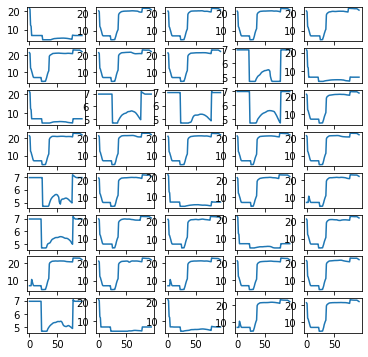

In [45]:
Nsamples = 40
gridRows = 8
sampleDays = dataclust[np.random.choice(dataclust.shape[0], Nsamples, replace=False), :]
plt.subplots(gridRows,Nsamples//gridRows, figsize=(6,6))
for i in range(Nsamples):
    plt.subplot(gridRows,Nsamples//gridRows,i+1)
    plt.plot(sampleDays[i])

In [ ]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import time
 
# define the standalone discriminator model
def define_discriminator(n_inputs=96):
	model = Sequential()
	model.add(Dense(24, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(12, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=96):
	model = Sequential()
	model.add(Dense(12, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(24, activation='relu'))
	model.add(Dense(n_outputs, activation='linear'))
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X = normy[np.random.choice(normy.shape[0], n, replace=False), :]
	# generate class labels
	y = ones((n, 1))
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
    ### ### ###  Reviewed for daytime power generation ### ### ###
	return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.plot(x_real[row], color='red')
	pyplot.plot(x_fake[row], color='blue')
	pyplot.show()
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=512, n_eval=500):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	t1 = time.time()
    
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)
			print(time.time()-t1)

# size of the latent space
latent_dim = 12
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, n_epochs =10000, n_eval = 1000)